In [8]:
import gc
import json
import pickle as pk
import random
import re
import time
from collections import Counter

import cv2
import easyocr
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pytesseract
import requests
import torch
from IPython.display import HTML
from matplotlib import animation
from transformers import (
    AutoModel,
    AutoModelForCausalLM,
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    pipeline,
)
from matplotlib.animation import FuncAnimation
from vidaug import augmentors as va

In [3]:
with open("../training/data/data_sampled_threshold_10.pkl", "rb") as f:
    X_data, Y_data = pk.load(f)

X_data[0]

'/home/lehoangchibach/Documents/Code/gif_analytics/templates/template_examples/91be88e0f31f774344846969c8931594_315139414.gif'

In [46]:
NUM_FRAMES = 5
IMAGE_SIZE = (224, 224)


def first_frame(video_path):
    cap = cv2.VideoCapture(video_path)

    # Check if the video was successfully opened
    if not cap.isOpened():
        raise Exception("Error: Could not open video.")
    else:
        # Read the first frame
        ret, frame = cap.read()
    cap.release()
    return frame


def draw_video(video, interval=250):
    fig = plt.figure()
    im = plt.imshow(video[0, :, :, :])

    plt.close()  # this is required to not display the generated image

    def init():
        im.set_data(video[0, :, :, :])

    def animate(i):
        im.set_data(video[i, :, :, :])
        return im

    anim = animation.FuncAnimation(
        fig, animate, init_func=init, frames=video.shape[0], interval=interval
    )
    return HTML(anim.to_html5_video())


def display_video_numpy(video_data):
    """
    Displays a NumPy array representing video data in a Jupyter Notebook.

    Args:
        video_data (numpy.ndarray): A NumPy array representing video data.
                                    Expected shape: (frames, height, width, channels) or (frames, height, width)
    """
    if video_data.ndim == 3:  # Grayscale video
        frames, height, width = video_data.shape
        channels = 1
    elif video_data.ndim == 4:  # Color video
        frames, height, width, channels = video_data.shape
    else:
        raise ValueError("Video data must be a 3D or 4D NumPy array.")

    fig, ax = plt.subplots()
    if channels == 1:
        im = ax.imshow(video_data[0], cmap="gray", animated=True)
    else:
        im = ax.imshow(video_data[0], animated=True)

    def update(frame):
        if channels == 1:
            im.set_array(video_data[frame])
        else:
            im.set_array(video_data[frame])
        return (im,)

    ani = FuncAnimation(
        fig, update, frames=frames, interval=200, blit=True
    )  # Adjust interval for playback speed
    plt.close()  # Prevents showing the static first frame

    return HTML(ani.to_html5_video())


def train_video_processor(video_path: str) -> np.ndarray:
    frames = []
    cap = cv2.VideoCapture(video_path)

    # Get total number of frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames <= 0:
        raise ValueError("Could not read frames from video file")

    # Calculate frame indices to extract
    frame_indices = [
        i * (total_frames - 1) // (NUM_FRAMES - 1) for i in range(NUM_FRAMES)
    ]

    for frame_idx in frame_indices:
        # Set frame position
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)

        # Read frame
        ret, frame = cap.read()
        if ret:
            # Convert BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            frames.append(frame_rgb)

    # Release video capture object
    cap.release()

    while len(frames) < 5:
        frames.append(frames[-1])

    seq = va.Sequential(
        [
            va.Pepper(),
            va.RandomShear(x=0.2, y=0.2),
            va.RandomTranslate(x=10, y=10),
            va.RandomRotate(20),
            va.Sometimes(0.5, va.HorizontalFlip()),
        ]
    )

    frames = seq(frames)
    # video_data = np.stack(frames)
    # video_data.astype(np.float32)

    res = []
    for frame in frames:
        res.append(cv2.resize(frame, IMAGE_SIZE))
    return np.array(res)


def test_video_processor(video_path: str) -> np.ndarray:
    frames = []
    cap = cv2.VideoCapture(video_path)

    # Get total number of frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames <= 0:
        raise ValueError("Could not read frames from video file")

    # Calculate frame indices to extract
    frame_indices = [
        i * (total_frames - 1) // (NUM_FRAMES - 1) for i in range(NUM_FRAMES)
    ]

    for frame_idx in frame_indices:
        # Set frame position
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)

        # Read frame
        ret, frame = cap.read()
        if ret:
            # Convert BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_rgb = cv2.resize(frame_rgb, IMAGE_SIZE)

            frames.append(frame_rgb)

    # Release video capture object
    cap.release()

    while len(frames) < 5:
        frames.append(frames[-1])

    video_data = np.stack(frames) / 255
    return video_data.astype(np.float32)


def test_random_video_processor(video_path: str) -> np.ndarray:
    frames = []
    cap = cv2.VideoCapture(video_path)

    # Get total number of frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames <= 0:
        raise ValueError("Could not read frames from video file")

    # Generate 5 unique random frame indices
    frame_indices = sorted(random.sample(range(total_frames), NUM_FRAMES))

    for frame_idx in frame_indices:
        # Set frame position
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)

        # Read frame
        ret, frame = cap.read()
        if ret:
            # Convert BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_rgb = cv2.resize(frame_rgb, IMAGE_SIZE)

            frames.append(frame_rgb)

    # Release video capture object
    cap.release()

    while len(frames) < 5:
        if frames:  # if there is any frame append the last one.
            frames.append(frames[-1])
        else:  # if there is no frame, create a black image
            black_image = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 3), dtype=np.uint8)
            frames.append(black_image)

    video_data = np.stack(frames) / 255
    return video_data.astype(np.float32)

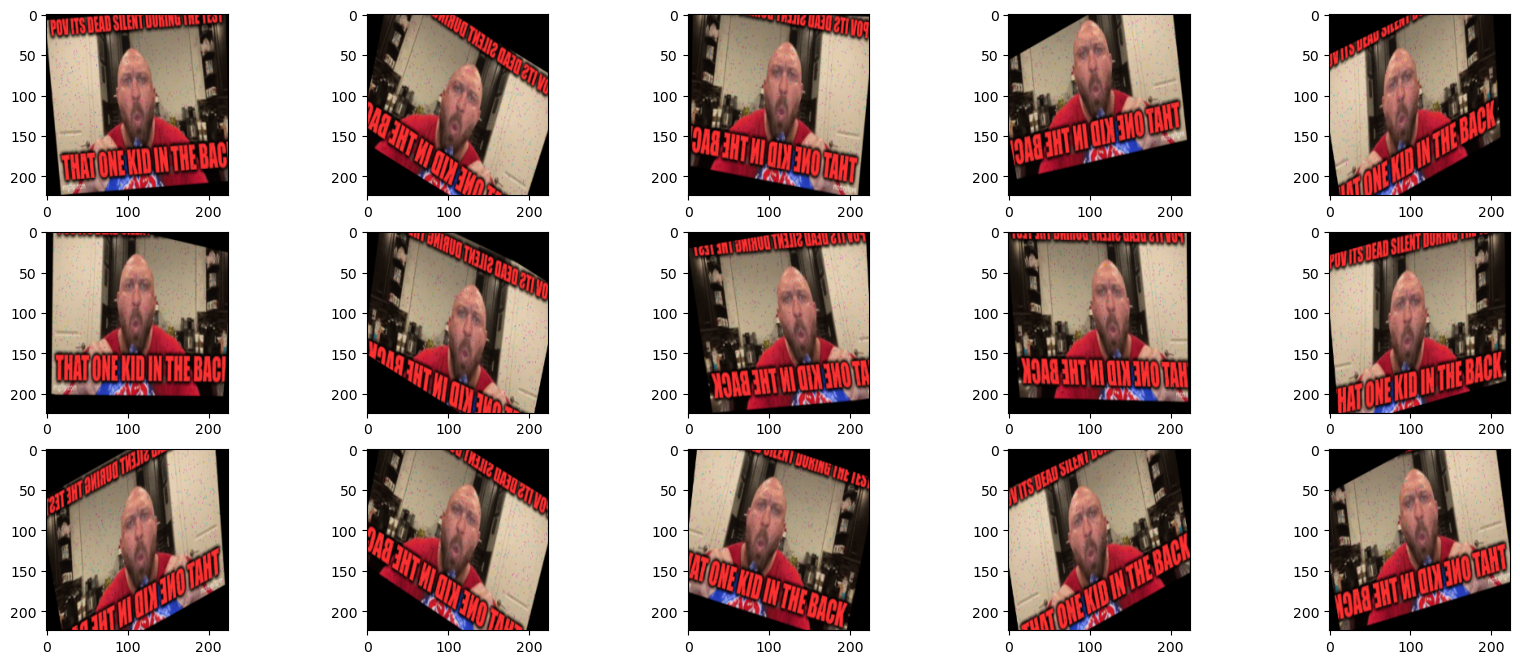

In [72]:
fig, axs = plt.subplots(3, 5, figsize=(20, 8))
for i, ax in enumerate(axs.flat):
    video_data = train_video_processor(X_data[0])
    image = video_data[0]
    ax.imshow(image)

plt.show()

In [54]:
idx = random.randint(0, len(X_data))
print(idx)
display_video_numpy(test_random_video_processor(X_data[4702]))

6616
